# Import and Loss

In [4]:
import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from datas import *
from set_train import *
from models.Transformers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
short = False
stock_symbol, end_date, num_class, batch_size, init, fp16_training, num_epochs, lr = set_train()
model = TransformerEncoderDecoder(num_class=num_class).to(device)
Model = model.model_type

### Loss Result

3.623423933982849


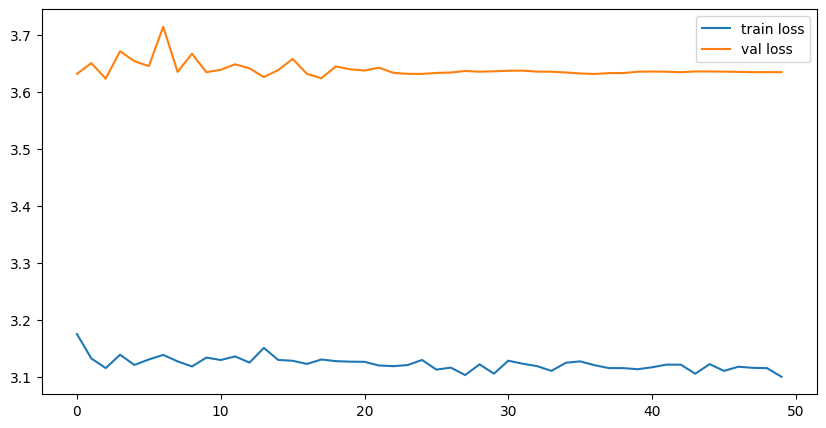

In [5]:
with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
    print(infos['min val loss'])

with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_TrainValHistLoss.pk', 'rb') as f:
    results = pickle.load(f)
    train_loss = results['train']
    val_loss = results['valid']
    
with open('Model_Result/min_loss.json', 'a') as file:
    import json
    json.dump({f'{Model}_class{num_class}_{stock_symbol}': infos['min val loss']}, file)
    file.write('\n')
    
plt.figure(figsize=(10, 5))
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.show()


### Data

In [6]:
# Data
trainloader, validloader, testloader, test_date, df, src = data()

src = src.permute(0, 2, 1).to(device)
x_valid = [x for x, y in validloader]
x_valid = torch.cat(x_valid, dim = 0)
for x, y in testloader:
    print(x.shape)
    break

100%|██████████| 2965/2965 [00:04<00:00, 732.81it/s]


x_train_len: 2128
torch.Size([64, 6, 10])


### Backtest 

In [7]:
def backtest_plot(normalize=False):    
    # Prediction
    model.load_state_dict(torch.load(f'Model_Result/{Model}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval() 
    """
    model.load_state_dict(torch.load(f'Temp/{Model}_class{num_class}_{stock_symbol}_checkpoint_LastTrainModel.pt'))
    """   
    y_pred, _, acc = test_encoderdecoder(model, src, testloader)
    prediction = pd.DataFrame(y_pred.detach().cpu().numpy())
        
    # Scaling with predicted valid set
    if normalize:
        y_train_pred, _, acc = test_encoderdecoder(model, src, validloader)
        scaler = StandardScaler()
        scaler.fit(y_train_pred.detach().cpu().numpy())
        prediction = pd.DataFrame(scaler.transform(prediction))
    
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    #   In Encoder Decoder need to ignore the last batch if last batch's batch size != batch_size
    #   so use date_test[:len(prediction)]
    prediction['Date'] = test_date[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')   
    true_and_pred['Close'] = true_and_pred['Close_origin'] # Close is normalised while use Close in training, set Close to original
    
    
    # Backtest 
    #   Get the predicted doc_1. 
    #   If class == 1 the the y_pred is the doc_1
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. For encoder-only and encoder-decoder since the second one need to drop last, 
    buy hold would not be the same
    """
    true_and_pred['doc_1'] /= 100
    asset = 1
    asset_buyhold = 1
    asset_list = []
    thres = 0.5 if normalize else 0.004
    
    if num_class == 1:        
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        for index, (c, pred, true) in df_backtest.iterrows():
            if pred > thres:
                asset *= (1 + true)
            if short and pred < -thres:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        # print(f'Buy Hold last asset: {asset_buyhold}')
            
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > thres:
                asset *= (1 + true)   
            if short and pred < -thres:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)

    # print(f'Accuracy: {acc}')
    print(f'Asset: {asset}')
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')
    return y_pred, df_backtest

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Asset: 0.934769519570334


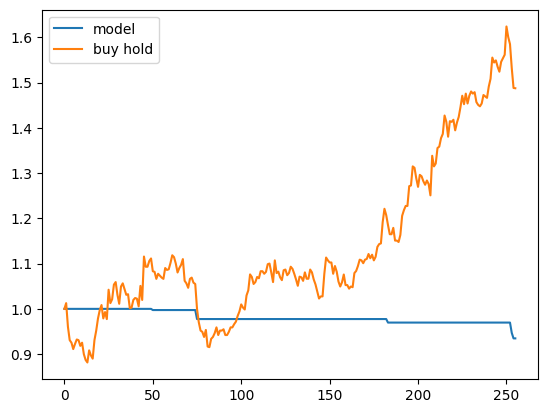

In [8]:
y_pred, df_b = backtest_plot()
torch.cuda.empty_cache()

In [9]:
y_pred

tensor([[-0.2442],
        [-0.3395],
        [-0.0514],
        [-0.0775],
        [-0.2183],
        [-0.1704],
        [-0.2963],
        [-0.3430],
        [-0.2533],
        [-0.2319],
        [-0.2673],
        [-0.1014],
        [-0.1493],
        [-0.2272],
        [-0.3719],
        [-0.2435],
        [-0.2019],
        [-0.3966],
        [-0.3753],
        [-0.3666],
        [-0.3558],
        [-0.3164],
        [-0.1189],
        [-0.2546],
        [-0.1256],
        [-0.5215],
        [-0.1045],
        [-0.2672],
        [-0.3828],
        [-0.2099],
        [-0.0646],
        [-0.0883],
        [-0.3375],
        [-0.2629],
        [-0.1643],
        [-0.1036],
        [-0.1576],
        [-0.0085],
        [-0.1537],
        [-0.2377],
        [-0.2205],
        [-0.1533],
        [-0.0448],
        [-0.3105],
        [-0.0457],
        [-0.5168],
        [-0.1680],
        [-0.1261],
        [-0.1733],
        [-0.1325],
        [ 0.0094],
        [-0.1110],
        [-0.

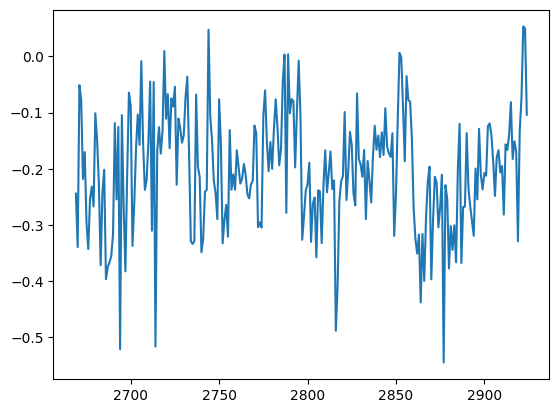

In [10]:
plt.plot(df_b['pred_doc_1'])

In [11]:
df_b.Close.iloc[-1]/df_b.Close.iloc[0]

1.4876027656403807

In [12]:
stock_symbol.split('.')[0]

'2454'